<a href="https://colab.research.google.com/github/annasajkh/VQGAN-CLIP-naive-implementation/blob/main/VQGAN%2BCLIP_upload_(naive_implementation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi #if you don't get Tesla T4 it would be really slow but it's still okay

Fri Apr 29 12:40:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install rudalle

import torch
import clip
from torch.optim import AdamW
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from rudalle import get_vae


normalize_clip = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

augmentation = nn.Sequential(
  transforms.RandomHorizontalFlip(0.5),
  transforms.RandomAffine(degrees=30, translate=(0.0, 0.3)),
  transforms.RandomCrop(size=(224, 224))
)

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _ = clip.load("ViT-B/32", device=device)

In [9]:
text = "fire and water niko #art #digitalart 4k wallpaper"

lr_init = 3e-4

steps = 1000

weight_decay = 0.1
 
image_augmentation_count = 4

show_interval = 50

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


  0%|          | 0/1000 [00:00<?, ?it/s]


fire and water niko #art #digitalart 4k wallpaper
Loss: 4.4375


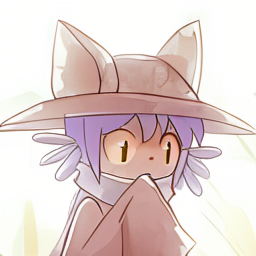

  5%|▌         | 50/1000 [00:16<04:53,  3.23it/s]


fire and water niko #art #digitalart 4k wallpaper
Loss: 2.462890625


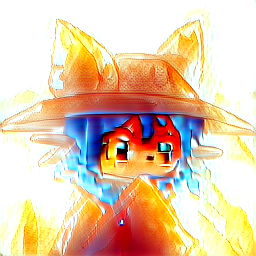

 10%|█         | 100/1000 [00:32<04:37,  3.24it/s]


fire and water niko #art #digitalart 4k wallpaper
Loss: 2.1796875


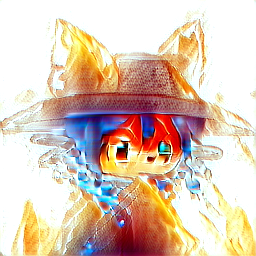

 12%|█▏        | 121/1000 [00:39<04:44,  3.09it/s]


KeyboardInterrupt: ignored

In [10]:
#uplod an image and name it "image.png" and the image should be square

from PIL import Image
import numpy as np

torch.cuda.empty_cache()
vae = get_vae().to(device)
torch.cuda.empty_cache()

text_tokenized = clip.tokenize([text]).to(device)

image = Image.open("image.png").resize((256,256), Image.BICUBIC)# <---- or you can just change the image path
image = np.array(image)

image = (torch.tensor(image).to(device).float() / 255)[None,:]
image = torch.permute(image, (0, 3, 1, 2))

code = vae.get_codebook_indices(image)

optimizer = AdamW(vae.parameters(), lr=lr_init, weight_decay=weight_decay)

for i in tqdm(range(steps)):
    y = vae.decode(code)
    img = normalize_clip(y)
    
    image = F.interpolate(img, (224, 224))

    images = torch.zeros(image_augmentation_count, 3, 224, 224).to(device)
    
    for j in range(image_augmentation_count - 1):
        images[j] = augmentation(image)
    
    images[-1] = image
    
    texts = torch.repeat_interleave(text_tokenized, image_augmentation_count, dim=0)
    
    loss = 1 / clip_model(images, texts)[0].mean() * 100
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % show_interval == 0:
        print("\n" + text)
        print("Loss: " + str(loss.item()))
        
        with torch.no_grad():
            generated = (y.permute(0, 2, 3, 1) * 255).to(torch.uint8)
            display(Image.fromarray(generated[0].cpu().numpy(), "RGB"))
    
    

print("\n" + text)
print("Loss: " + str(loss.item()))

with torch.no_grad():
    generated = (y.permute(0, 2, 3, 1) * 255).to(torch.uint8)
    display(Image.fromarray(generated[0].cpu().numpy(), "RGB"))


del vae
torch.cuda.empty_cache()